In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import fanc
import fanc.plotting
from scipy import ndimage as ndi
import matplotlib.patches as patches
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable

/Users/fardinhaque/Downloads/SJSU/Research/tools/biopython/Bio/__init__.py:138: BiopythonWarning: You may be importing Biopython from inside the source tree. This is bad practice and might lead to downstream issues. In particular, you might encounter ImportErrors due to missing compiled C extensions. We recommend that you try running your code from outside the source tree. If you are outside the source tree then you have a setup.py file in an unexpected directory: /Users/fardinhaque/Downloads/SJSU/Research/tools/biopython
  warnings.warn(


In [59]:
def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out

def highlight_features(dataframe, region, color, a, axes):
    try:
        features = dataframe.loc[region].values.tolist()
        if type(features[0]) == int:
            _, x_min, x_max, y_min, y_max = features
            rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1.2,
                                     edgecolor=color, facecolor='none')
            axes[a].add_patch(rect)
        else:
            for f in features:
                _, x_min, x_max, y_min, y_max = f
                rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1.2,
                                         edgecolor=color, facecolor='none')
                axes[a].add_patch(rect)
                
    except KeyError:
        next

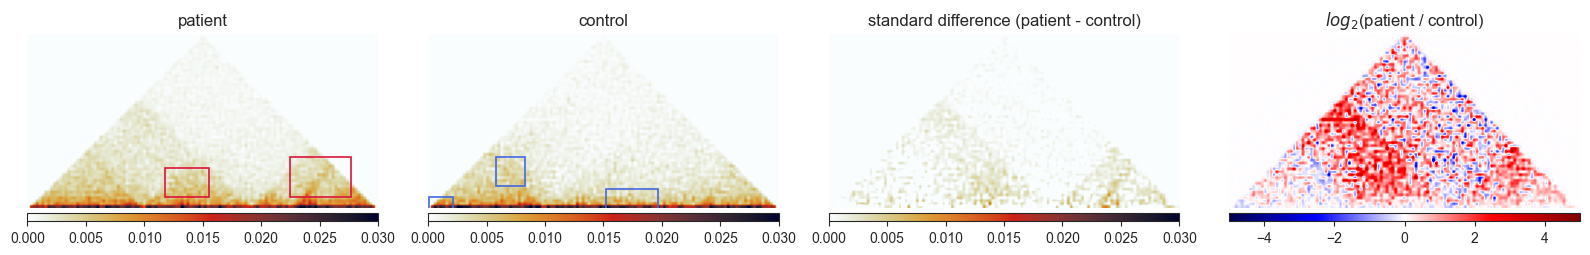

In [62]:
winsize = "3mb"
wdir = "./"
region_pairs = "hg38_chr2_{}_win_100kb_step.bed".format(winsize)

gained = pd.read_csv(wdir + 'gained_features.tsv', delimiter=',', usecols=[0, 1, 2, 3,4, 5], header=None, index_col=[0])
lost = pd.read_csv(wdir + 'lost_features.tsv', delimiter=',', usecols=[0, 1, 2, 3, 4, 5], header=None, index_col=[0])

regions = pd.read_csv(wdir + region_pairs, sep='\t', header=None)

patient_hic = fanc.load(wdir + "ukm_patient_fixed_le_25kb_chr2.hic")
control_hic = fanc.load(wdir + "ukm_control_fixed_le_25kb_chr2.hic")

reg = 1448

window_start, window_end = regions.loc[reg][1:3]

region_string = "chr2:{}-{}".format(window_start, window_end)

patient_region_sub = patient_hic[region_string, region_string].data
control_region_sub = control_hic[region_string, region_string].data

min_v = min(
    [
        np.min(np.extract(patient_region_sub>0 , patient_region_sub)),
        np.min(np.extract(control_region_sub>0 , control_region_sub))
    ]
)

patient_region_sub += min_v
control_region_sub += min_v

l2fcm = np.log2(patient_region_sub / control_region_sub)
zml2 = clipped_zoom(l2fcm, 0.7)
rot_l2 = ndi.rotate(zml2, 45, reshape=False)

# Standard diff calculation
diff = patient_region_sub - control_region_sub
clipped = clipped_zoom(diff, 0.7)
diff_plot = ndi.rotate(clipped, 45, reshape=False)

fig, axes = plt.subplots(1, 4, figsize=(16, 8))

axes[0].set_title('patient')
axes[1].set_title('control')
axes[2].set_title('standard difference (patient - control)')
axes[3].set_title('$log_2$(patient / control)')

# clipped zoom and rotate patient and control and keep only half-matrix
zm1 = clipped_zoom(control_region_sub, 0.7)
rot_control = ndi.rotate(zm1, 45, reshape=False)

zm2 = clipped_zoom(patient_region_sub, 0.7)
rot_patient = ndi.rotate(zm2, 45, reshape=False)

middle = int(np.shape(rot_control)[1]/ 2.)

m1 = axes[0].imshow(rot_patient[:middle, :], vmin=0, vmax=0.03, cmap='germany')
m2 = axes[1].imshow(rot_control[:middle,:], vmin=0, vmax=0.03, cmap='germany')

# highlight features from CHESS paper commented out
# per region check if identified features, to highlight
highlight_features(gained, reg, 'crimson', 0, axes)
highlight_features(lost, reg, 'royalblue', 1, axes)

# patient - control standard diff 
m3 = axes[2].imshow(diff_plot[:middle,:], vmin=0, vmax=0.03, cmap='germany')

# original log(patient/control) calc plot from chess
m4 = axes[3].imshow(rot_l2[:middle,:], cmap='seismic', vmax=5, vmin=-5)

for m, ax in zip([m1, m2, m3, m4], axes):
    ax.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.05)
    fig.colorbar(m, cax=cax, orientation='horizontal')

plt.tight_layout()